In [1]:
import sys
import time
import traceback
import os
from arduino_iot_cloud import ArduinoCloudClient
import csv 
import time
import plotly.io as pio
import plotly.express as px
import pandas as pd
import seaborn as sns
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import pandas as pd
import matplotlib.pyplot as plt

/Users/vanimiddha/Documents/arduino.py/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
! pip install pandas seaborn matplotlib dash plotly arduino-iot-cloud

  Using cached matplotlib-3.9.4-cp39-cp39-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached plotly-6.0.1-py3-none-any.whl.metadata (6.7 kB)
  Using cached contourpy-1.3.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.7-cp39-cp39-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached flask-3.0.3-py3-none-any.whl.metadata (3.2 kB)
  Using cached werkzeug-3.0.6-py3-none-any.whl.metadata (3.7 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached retrying-1.3.4-py3-none-any.whl.metadata (6.9 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
  Using cached blinker-1.9.0-py3-no

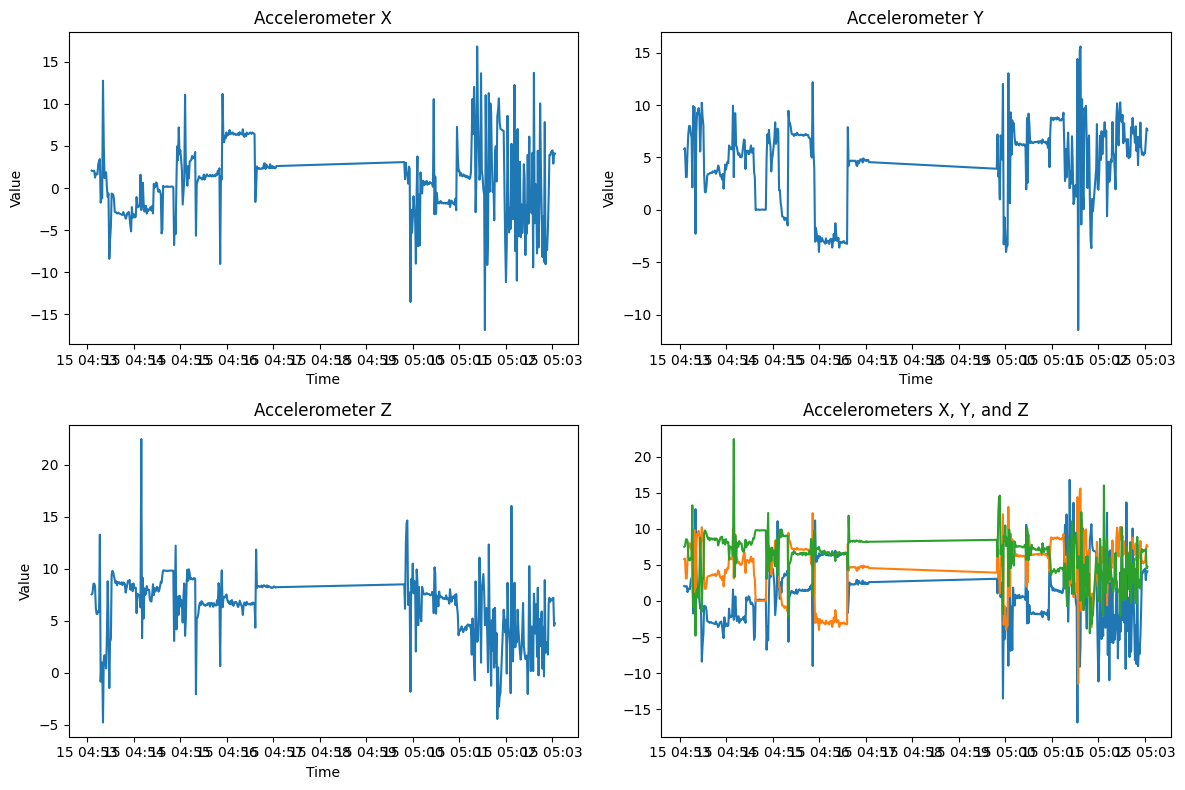

In [2]:

# Load the data
accelerometer_x = pd.read_csv('Accelerometer_X.csv')
accelerometer_y = pd.read_csv('Accelerometer_Y.csv')
accelerometer_z = pd.read_csv('Accelerometer_Z.csv')

accelerometer_x.time = pd.to_datetime(accelerometer_x.time)
accelerometer_y.time = pd.to_datetime(accelerometer_y.time)
accelerometer_z.time = pd.to_datetime(accelerometer_z.time)

# Plotting accelerometer_x
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(accelerometer_x['time'], accelerometer_x['value'])
plt.title('Accelerometer X')

# Plotting accelerometer_y
plt.subplot(2, 2, 2)
plt.plot(accelerometer_y['time'], accelerometer_y['value'])
plt.title('Accelerometer Y')

# Plotting accelerometer_z
plt.subplot(2, 2, 3)
plt.plot(accelerometer_z['time'], accelerometer_z['value'])
plt.title('Accelerometer Z')

# Plotting all three accelerometers
plt.subplot(2, 2, 4)
plt.plot(accelerometer_x['time'], accelerometer_x['value'], label='X')
plt.plot(accelerometer_y['time'], accelerometer_y['value'], label='Y')
plt.plot(accelerometer_z['time'], accelerometer_z['value'], label='Z')
plt.title('Accelerometers X, Y, and Z')


for i in range(3):
    plt.subplot(2,2,i+1)
    plt.xlabel('Time')
    plt.ylabel('Value')

plt.tight_layout()
plt.show()


In [ ]:
### Receiving the data from Python

In [3]:

# Initialize Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Graph(id='live-update-graph'),
    dcc.Interval(id='interval-component', interval=1000, n_intervals=0)  # Update every second  
])

@app.callback(
    Output('live-update-graph', 'figure'),
    Input('interval-component', 'n_intervals')
)

def update_graph(n_intervals):
    global cur_data
    # Convert to DataFrame for Plotly
    df = pd.DataFrame(cur_data, columns=['index','Timestamp', 'X', 'Y', 'Z'])
    fig = px.line(df, x= 'Timestamp', y = ['X','Y','Z'])  # Scatter plot

    return fig

In [4]:
import sys
import time
import traceback
import os
from arduino_iot_cloud import ArduinoCloudClient
import csv

DEVICE_ID = "1749c2d8-13f5-4e91-b6a7-5d2f51521a35"
SECRET_KEY = "Wj4TwGE4teSzICUOkk!51plZ0"

# Define the variables to store the accelerometer data
cur_data = []
temp_data = []
x, y, z = 0, 0, 0
count = 0
N_SAMPLES = 20

# =============================================================================
# Define the callback function for accelerometer_x changes
def on_accelerometer_x_changed(client, value):
    global x
    x = value

# Define the callback function for accelerometer_y changes
def on_accelerometer_y_changed(client, value):
    global y
    y = value

# Define the callback function for accelerometer_z changes
def on_accelerometer_z_changed(client, value):
    global z
    z = value
            
#================================= MAIN FUNCTION =================================
if __name__ == "__main__":
    try:
        # Instantiate Arduino cloud client
        client = ArduinoCloudClient(device_id=DEVICE_ID, username=DEVICE_ID, password=SECRET_KEY, sync_mode = True)
        
        # Register the callback functions
        client.register("py_x", value=None, on_write=on_accelerometer_x_changed)
        client.register("py_y", value=None, on_write=on_accelerometer_y_changed)
        client.register("py_z", value=None, on_write=on_accelerometer_z_changed)

        client.start()

        # Keep the client running
        while True:
            if x is not None and y is not None and z is not None:
                if count < N_SAMPLES:
                    count += 1
                    timestamp = time.strftime('%Y-%m-%d %H:%M:%S')
                    temp_data.append([count,timestamp,x,y,z])
                    print([count,timestamp,x,y,z])
                    x, y, z = None, None, None
                else:
                    timestamp = time.strftime('%Y-%m-%d_%H-%M-%S')
                    df = pd.DataFrame(temp_data, columns=['index','Timestamp', 'X', 'Y', 'Z'])
                    df.to_csv(f"csv_{timestamp}.csv")
                    fig = px.line(df, x= 'Timestamp', y = ['X','Y','Z'])  # Scatter plot
                    filename = f"images/plot_{timestamp}.png"  # Correct filename format
                    pio.write_image(fig, filename)
                    count = 0
                    cur_data = temp_data.copy()
                    temp_data.clear()
            client.update()
    except:
        exc_type, exc_value, exc_traceback = sys.exc_info()
        traceback.print_tb(exc_type, file=print)

[1, '2025-04-16 15:00:02', 0, 0, 0]
[2, '2025-04-16 15:00:02', -4.72495698928833, -0.15921440720558167, 9.99100399017334]
[3, '2025-04-16 15:00:03', 1.092953085899353, -2.6587610244750977, 11.130643844604492]
[4, '2025-04-16 15:00:04', -2.675520420074463, 3.8534677028656006, -0.33758243918418884]
[5, '2025-04-16 15:00:05', 2.01232647895813, -1.5957354307174683, 10.220847129821777]
[6, '2025-04-16 15:00:06', 3.051409959793091, 2.2828712463378906, 10.474632263183594]
[7, '2025-04-16 15:00:07', 7.020996570587158, 7.961917877197266, -1.2234370708465576]
[8, '2025-04-16 15:00:08', 3.0561983585357666, 8.943540573120117, 4.153939723968506]
[9, '2025-04-16 15:00:09', -1.780089020729065, 1.6891093254089355, 8.04691219329834]
[10, '2025-04-16 15:00:10', -3.0394389629364014, 4.179079055786133, 0.016759412363171577]
[11, '2025-04-16 15:00:11', -3.360262155532837, -3.7840356826782227, 15.109807014465332]
[12, '2025-04-16 15:00:12', -14.296975135803223, -11.148600578308105, 26.151865005493164]
[13, 

AttributeError: type object 'ValueError' has no attribute 'tb_frame'

In [ ]:
app.run_server(debug_mode = True, jupyter_tab = True)

In [ ]:
_df = pd.read_csv("csv_2024-08-31_01-47-29.csv")
_df.drop(columns ={"Unnamed: 0", "index"}, inplace = True)
_df.Timestamp = pd.to_datetime(_df.Timestamp)
_df.set_index("Timestamp", inplace = True)

In [13]:
import pandas as pd

# Load the data
df = pd.read_csv("csv_2025-04-16_15-00-21.csv", index_col=2)  # Timestamp is column index 2
df.index = pd.to_datetime(df.index)  # Convert index to datetime

# Optional: Sort by Timestamp just in case
df.sort_index(inplace=True)

# Create 5 activity segments using time-based filtering
act_1 = df.between_time("15:00:02", "15:00:05")  # Rows 0–4
act_2 = df.between_time("15:00:06", "15:00:10")  # Rows 5–9
act_3 = df.between_time("15:00:11", "15:00:14")  # Rows 10–13
act_4 = df.between_time("15:00:15", "15:00:17")  # Rows 14–16
act_5 = df.between_time("15:00:18", "15:00:20")  # Rows 17–19


In [14]:
act_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5 entries, 2025-04-16 15:00:02 to 2025-04-16 15:00:05
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5 non-null      int64  
 1   index       5 non-null      int64  
 2   X           5 non-null      float64
 3   Y           5 non-null      float64
 4   Z           5 non-null      float64
dtypes: float64(3), int64(2)
memory usage: 240.0 bytes


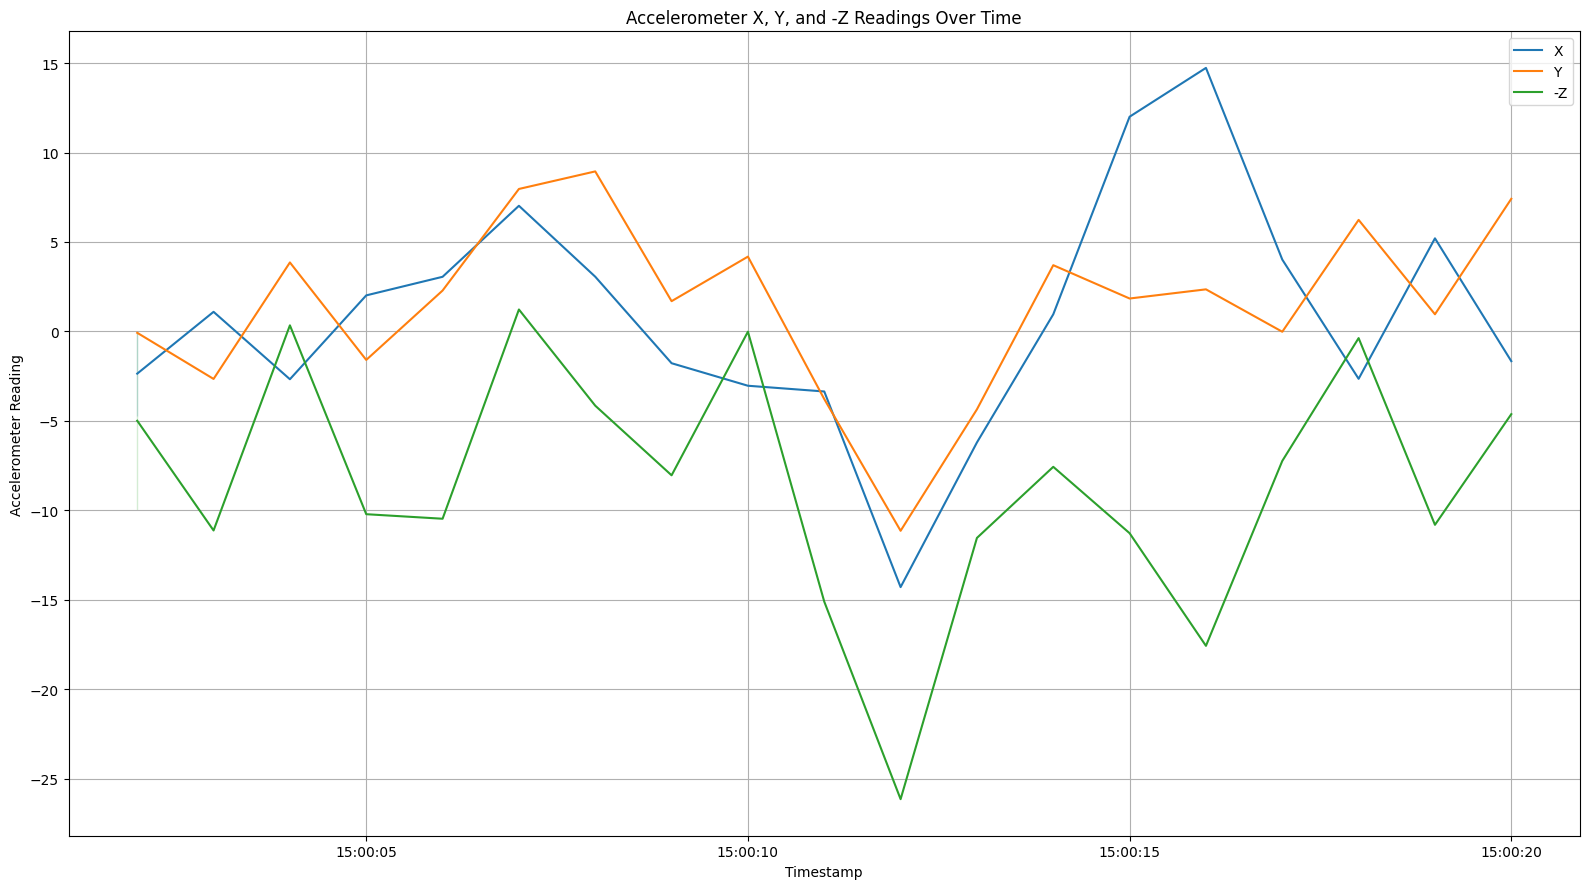

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file (replace the path with your file's path)
csv_file = "csv_2025-04-16_15-00-21.csv"
df = pd.read_csv(csv_file)

# Convert 'Timestamp' column to datetime format and set it as the DataFrame index
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df.set_index("Timestamp", inplace=True)

# Plot the accelerometer readings
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y=df["X"], label="X")
sns.lineplot(x=df.index, y=df["Y"], label="Y")
sns.lineplot(x=df.index, y=-df["Z"], label="-Z")  # Invert Z if needed for visual clarity

# Customize the plot with labels and title
plt.xlabel("Timestamp")
plt.ylabel("Accelerometer Reading")
plt.title("Accelerometer X, Y, and -Z Readings Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


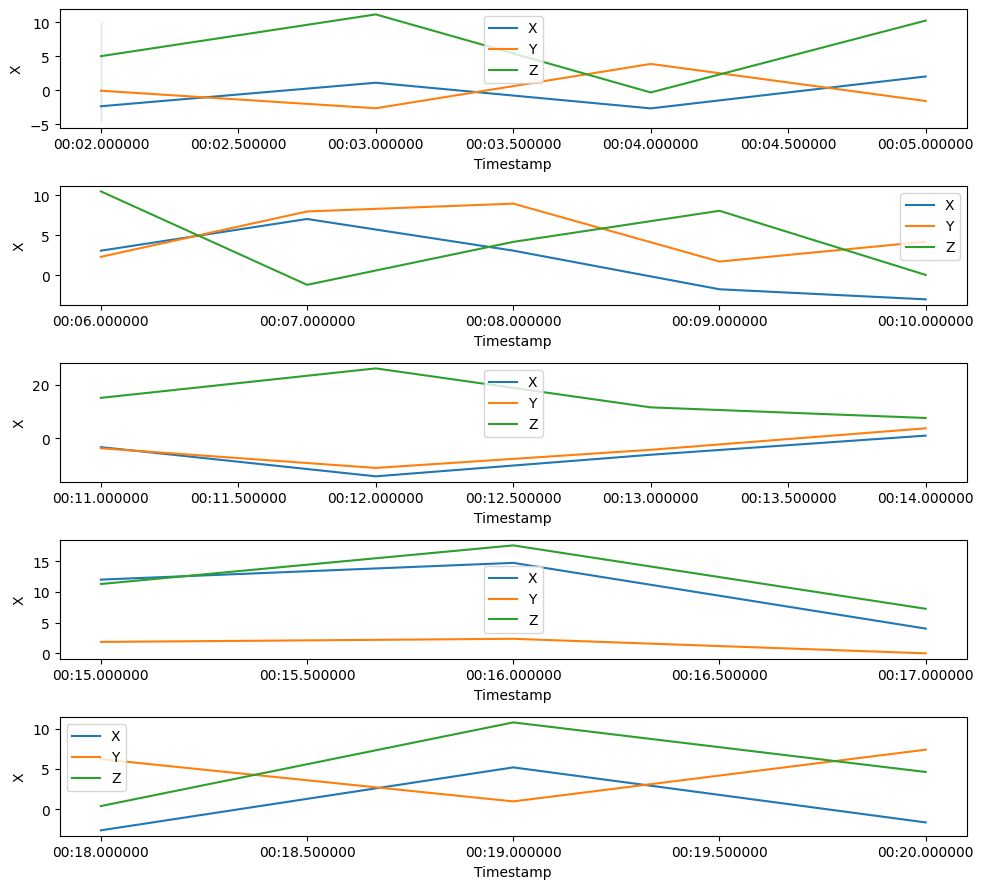

In [19]:
fig, ax = plt.subplots(5, figsize = (10,9))

for i, data in enumerate([act_1,act_2,act_3,act_4,act_5]):
    sns.lineplot(x=data.index, y=data["X"], label="X", ax = ax[i])
    sns.lineplot(x=data.index, y=data["Y"], label="Y", ax = ax[i])
    sns.lineplot(x=data.index, y=data["Z"], label="Z", ax = ax[i])
    ax[i].legend()

plt.tight_layout()
plt.show()

In [20]:
act_1.describe()

,Unnamed: 0,index,X,Y,Z
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,2.000000,3.000000,-0.859040,-0.112049,6.200983
std,1.581139,1.581139,2.785583,2.471193,5.831598
min,0.000000,1.000000,-4.724957,-2.658761,-0.337582
25%,1.000000,2.000000,-2.675520,-1.595735,0.000000
50%,2.000000,3.000000,0.000000,-0.159214,9.991004
75%,3.000000,4.000000,1.092953,0.000000,10.220847
max,4.000000,5.000000,2.012326,3.853468,11.130644


In [21]:
act_2.describe()

,Unnamed: 0,index,X,Y,Z
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,7.000000,8.000000,1.661815,5.011304,4.293761
std,1.581139,1.581139,4.078744,3.291752,5.025960
min,5.000000,6.000000,-3.039439,1.689109,-1.223437
25%,6.000000,7.000000,-1.780089,2.282871,0.016759
50%,7.000000,8.000000,3.051410,4.179079,4.153940
75%,8.000000,9.000000,3.056198,7.961918,8.046912
max,9.000000,10.000000,7.020997,8.943541,10.474632
